# Final Project
---

### By: Chris Vaisnor

### System Setup
- OS: Ubuntu 22.04.2 LTS
- Python Version: 3.10.12

In [1]:
import os
import torch
import torchvision
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from PIL import Image
from torch.optim import lr_scheduler
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

cudnn.benchmark = True
plt.ion()   # interactive mode

/home/chris/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
print('PyTorch Version: ', torch.__version__)
print('CUDA Available: ', torch.cuda.is_available())
print('Device Type: ', torch.cuda.get_device_name(0))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

PyTorch Version:  2.1.0+cu121
CUDA Available:  True
Device Type:  NVIDIA GeForce RTX 4090


In [3]:
class MinecraftImageClassification(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.classes = os.listdir(self.root_dir)
        self.filenames = []
        self.class_indices = []

        for class_index, dataset_class in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, dataset_class)
            class_filenames = os.listdir(class_dir)

            self.filenames += list(map(lambda x: os.path.join(class_dir, x), class_filenames))
            self.class_indices += [class_index]*len(class_filenames)

        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        image = Image.open(self.filenames[idx])
        class_index = self.class_indices[idx]

        if self.transform:
            image = self.transform(image)

        return image, class_index

In [4]:
# transformations for the training images based on ResNet normalization requirements https://pytorch.org/hub/pytorch_vision_resnet/
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = MinecraftImageClassification(root_dir='frames_biomes/train', transform=transform)
test_dataset = MinecraftImageClassification(root_dir='frames_biomes/test', transform=transform)

# info about the datasets
print('Train dataset size: ', len(train_dataset))
print('Test dataset size: ', len(test_dataset))
print('Number of classes: ', len(train_dataset.classes))

Train dataset size:  1600
Test dataset size:  400
Number of classes:  10


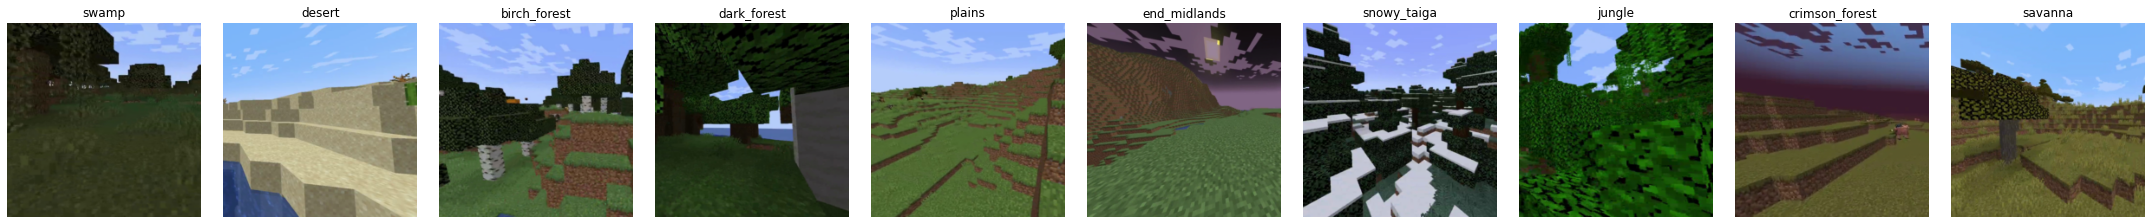

In [5]:
def show_images(dataset):
    num_classes = len(dataset.classes)
    fig, axs = plt.subplots(1, num_classes, figsize=(3*num_classes, 3), constrained_layout=True)

    for i, dataset_class in enumerate(dataset.classes):
        class_idx = dataset.class_indices.index(i)
        image, _ = dataset[class_idx]
        
        # if the dataset has 'transform' attribute and it is not None
        if getattr(dataset, "transform") and dataset.transform is not None:
            # unnormalize images for display
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std * image.permute(1,2,0).numpy() + mean
            image = np.clip(image, 0, 1)
        
        axs[i].imshow(image)
        axs[i].set_title(dataset_class)
        axs[i].axis('off')
    plt.show()

show_images(train_dataset)

In [6]:
from torch.utils.data import DataLoader, random_split

val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size

# ensure the randomness of the splitting process different every time you run the code
torch.manual_seed(0) 

train_dataset_split, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 8

train_loader = DataLoader(train_dataset_split, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Train dataloader size: ', len(train_loader))
print('Validation dataloader size: ', len(val_loader))
print('Test dataloader size: ', len(test_loader))

Train dataloader size:  160
Validation dataloader size:  40
Test dataloader size:  50


In [7]:
from torchvision import models
from torchvision.models.resnet import ResNet18_Weights
from torchvision.models.resnet import ResNet152_Weights
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_classes = len(train_dataset.classes)

model = models.resnet18(weights=ResNet18_Weights)
# model = models.resnet152(weights=ResNet152_Weights)

# get the number of input features to the last layer
n_inputs = model.fc.in_features 

# redefine the last layer (fully connected layer) to match the number of classes in our dataset
model.fc = nn.Linear(n_inputs, num_classes)

model = model.to(device)

# Cross-entropy Loss and SGD with momentum
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/home/chris/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_loader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_loader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def test_model(model):
    model.eval()   # Set model to evaluation mode

    running_corrects = 0

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
                        
        running_corrects += torch.sum(preds == labels.data)
            
    acc = running_corrects.double() / len(test_loader.dataset)

    print('Test Acc: {:.4f}'.format(acc))

    # graph 5 random test images with their predicted and true labels
    fig, axs = plt.subplots(1, num_classes, figsize=(25, 5), constrained_layout=True)
    for i in range(num_classes):
        idx = np.random.randint(0, len(test_loader.dataset))
        inputs, labels = test_loader.dataset[idx]
        inputs = inputs.unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        # unnormalize images for display
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inputs = std * inputs.squeeze().permute(1,2,0).cpu().numpy() + mean
        inputs = np.clip(inputs, 0, 1)

        axs[i].imshow(inputs)
        axs[i].set_title('Predicted: {}\nActual: {}'.format(test_dataset.classes[preds.item()], test_dataset.classes[labels]))
        axs[i].axis('off')

    plt.show()

In [9]:
trained_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

/home/chris/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "



Epoch 0/4


100%|██████████| 160/160 [00:12<00:00, 12.70it/s]


train Loss: 0.6992 Acc: 0.8055


100%|██████████| 40/40 [00:02<00:00, 15.91it/s]


val Loss: 0.0576 Acc: 0.9906

Epoch 1/4


100%|██████████| 160/160 [00:11<00:00, 14.26it/s]


train Loss: 0.1544 Acc: 0.9656


100%|██████████| 40/40 [00:02<00:00, 14.14it/s]


val Loss: 0.0334 Acc: 0.9906

Epoch 2/4


100%|██████████| 160/160 [00:10<00:00, 14.83it/s]


train Loss: 0.1151 Acc: 0.9711


100%|██████████| 40/40 [00:02<00:00, 15.31it/s]


val Loss: 0.0176 Acc: 1.0000

Epoch 3/4


100%|██████████| 160/160 [00:11<00:00, 13.71it/s]


train Loss: 0.1158 Acc: 0.9719


100%|██████████| 40/40 [00:02<00:00, 15.15it/s]


val Loss: 0.0166 Acc: 0.9969

Epoch 4/4


100%|██████████| 160/160 [00:12<00:00, 12.50it/s]


train Loss: 0.0646 Acc: 0.9859


100%|██████████| 40/40 [00:02<00:00, 14.41it/s]

val Loss: 0.0261 Acc: 0.9906
Best val Acc: 1.000000


Test Acc: 0.9950


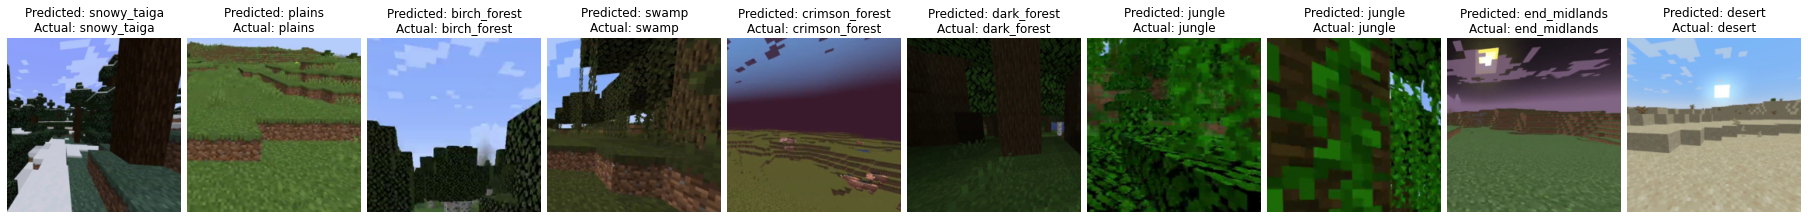

In [19]:
test_model(trained_model)